In [1]:
# Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
    
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


I0000 00:00:1729562146.109222     902 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729562146.157603     902 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729562146.159210     902 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [112]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_context('talk')

In [113]:
prefix = 's3://danylo-ucla/app/storage/weather/jobs/transform_batch/20220925-014051_e32aa567fa482e970513332d1d24fd51'

train_X = pd.read_parquet(f'{prefix}/train_x.parquet')
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')

validate_X = pd.read_parquet(f'{prefix}/validate_x.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')

test_X = pd.read_parquet(f'{prefix}/test_x.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

score_X = pd.read_parquet(f'{prefix}/score_x.parquet')

condition_window = 24
prediction_window = 24
features_length = 7

In [114]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 826464 entries, ('Albuquerque/1108/0', Timestamp('2015-02-16 09:00:00')) to ('Vancouver/806/12', Timestamp('2014-07-03 04:00:00'))
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   temperature  826464 non-null  float64
 1   humidity     826464 non-null  float64
 2   pressure     826464 non-null  float64
 3   wind_speed   826464 non-null  float64
dtypes: float64(4)
memory usage: 31.9+ MB


In [115]:
score_X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 57576 entries, ('Albuquerque/2249/0', Timestamp('2017-07-15 13:00:00')) to ('Vancouver/2623/10', Timestamp('2017-07-07 20:00:00'))
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  57576 non-null  float64
 1   humidity     57576 non-null  float64
 2   pressure     57576 non-null  float64
 3   wind_speed   57576 non-null  float64
dtypes: float64(4)
memory usage: 2.1+ MB


In [116]:
train_X.groupby('sample').size().head()

sample
Albuquerque/1108/0    24
Albuquerque/1108/1    24
Albuquerque/1108/2    24
Albuquerque/1112/0    24
Albuquerque/1112/1    24
dtype: int64

In [117]:
train_X.loc['Albuquerque/1112/1'].head(24)

,temperature,humidity,pressure,wind_speed
time,,,,
2015-02-20 18:00:00,282.116500,46.0,1023.0,3.0
2015-02-20 19:00:00,287.061667,40.0,1021.0,4.0
2015-02-20 20:00:00,288.236333,38.0,1019.0,4.0
2015-02-20 21:00:00,286.928000,35.0,1020.0,4.0
2015-02-20 22:00:00,288.930333,34.0,1017.0,5.0
2015-02-20 23:00:00,288.449667,31.0,1017.0,5.0
2015-02-21 00:00:00,286.976000,30.0,1019.0,4.0
2015-02-21 01:00:00,286.826333,27.0,1018.0,5.0
2015-02-21 02:00:00,285.683667,26.0,1019.0,5.0


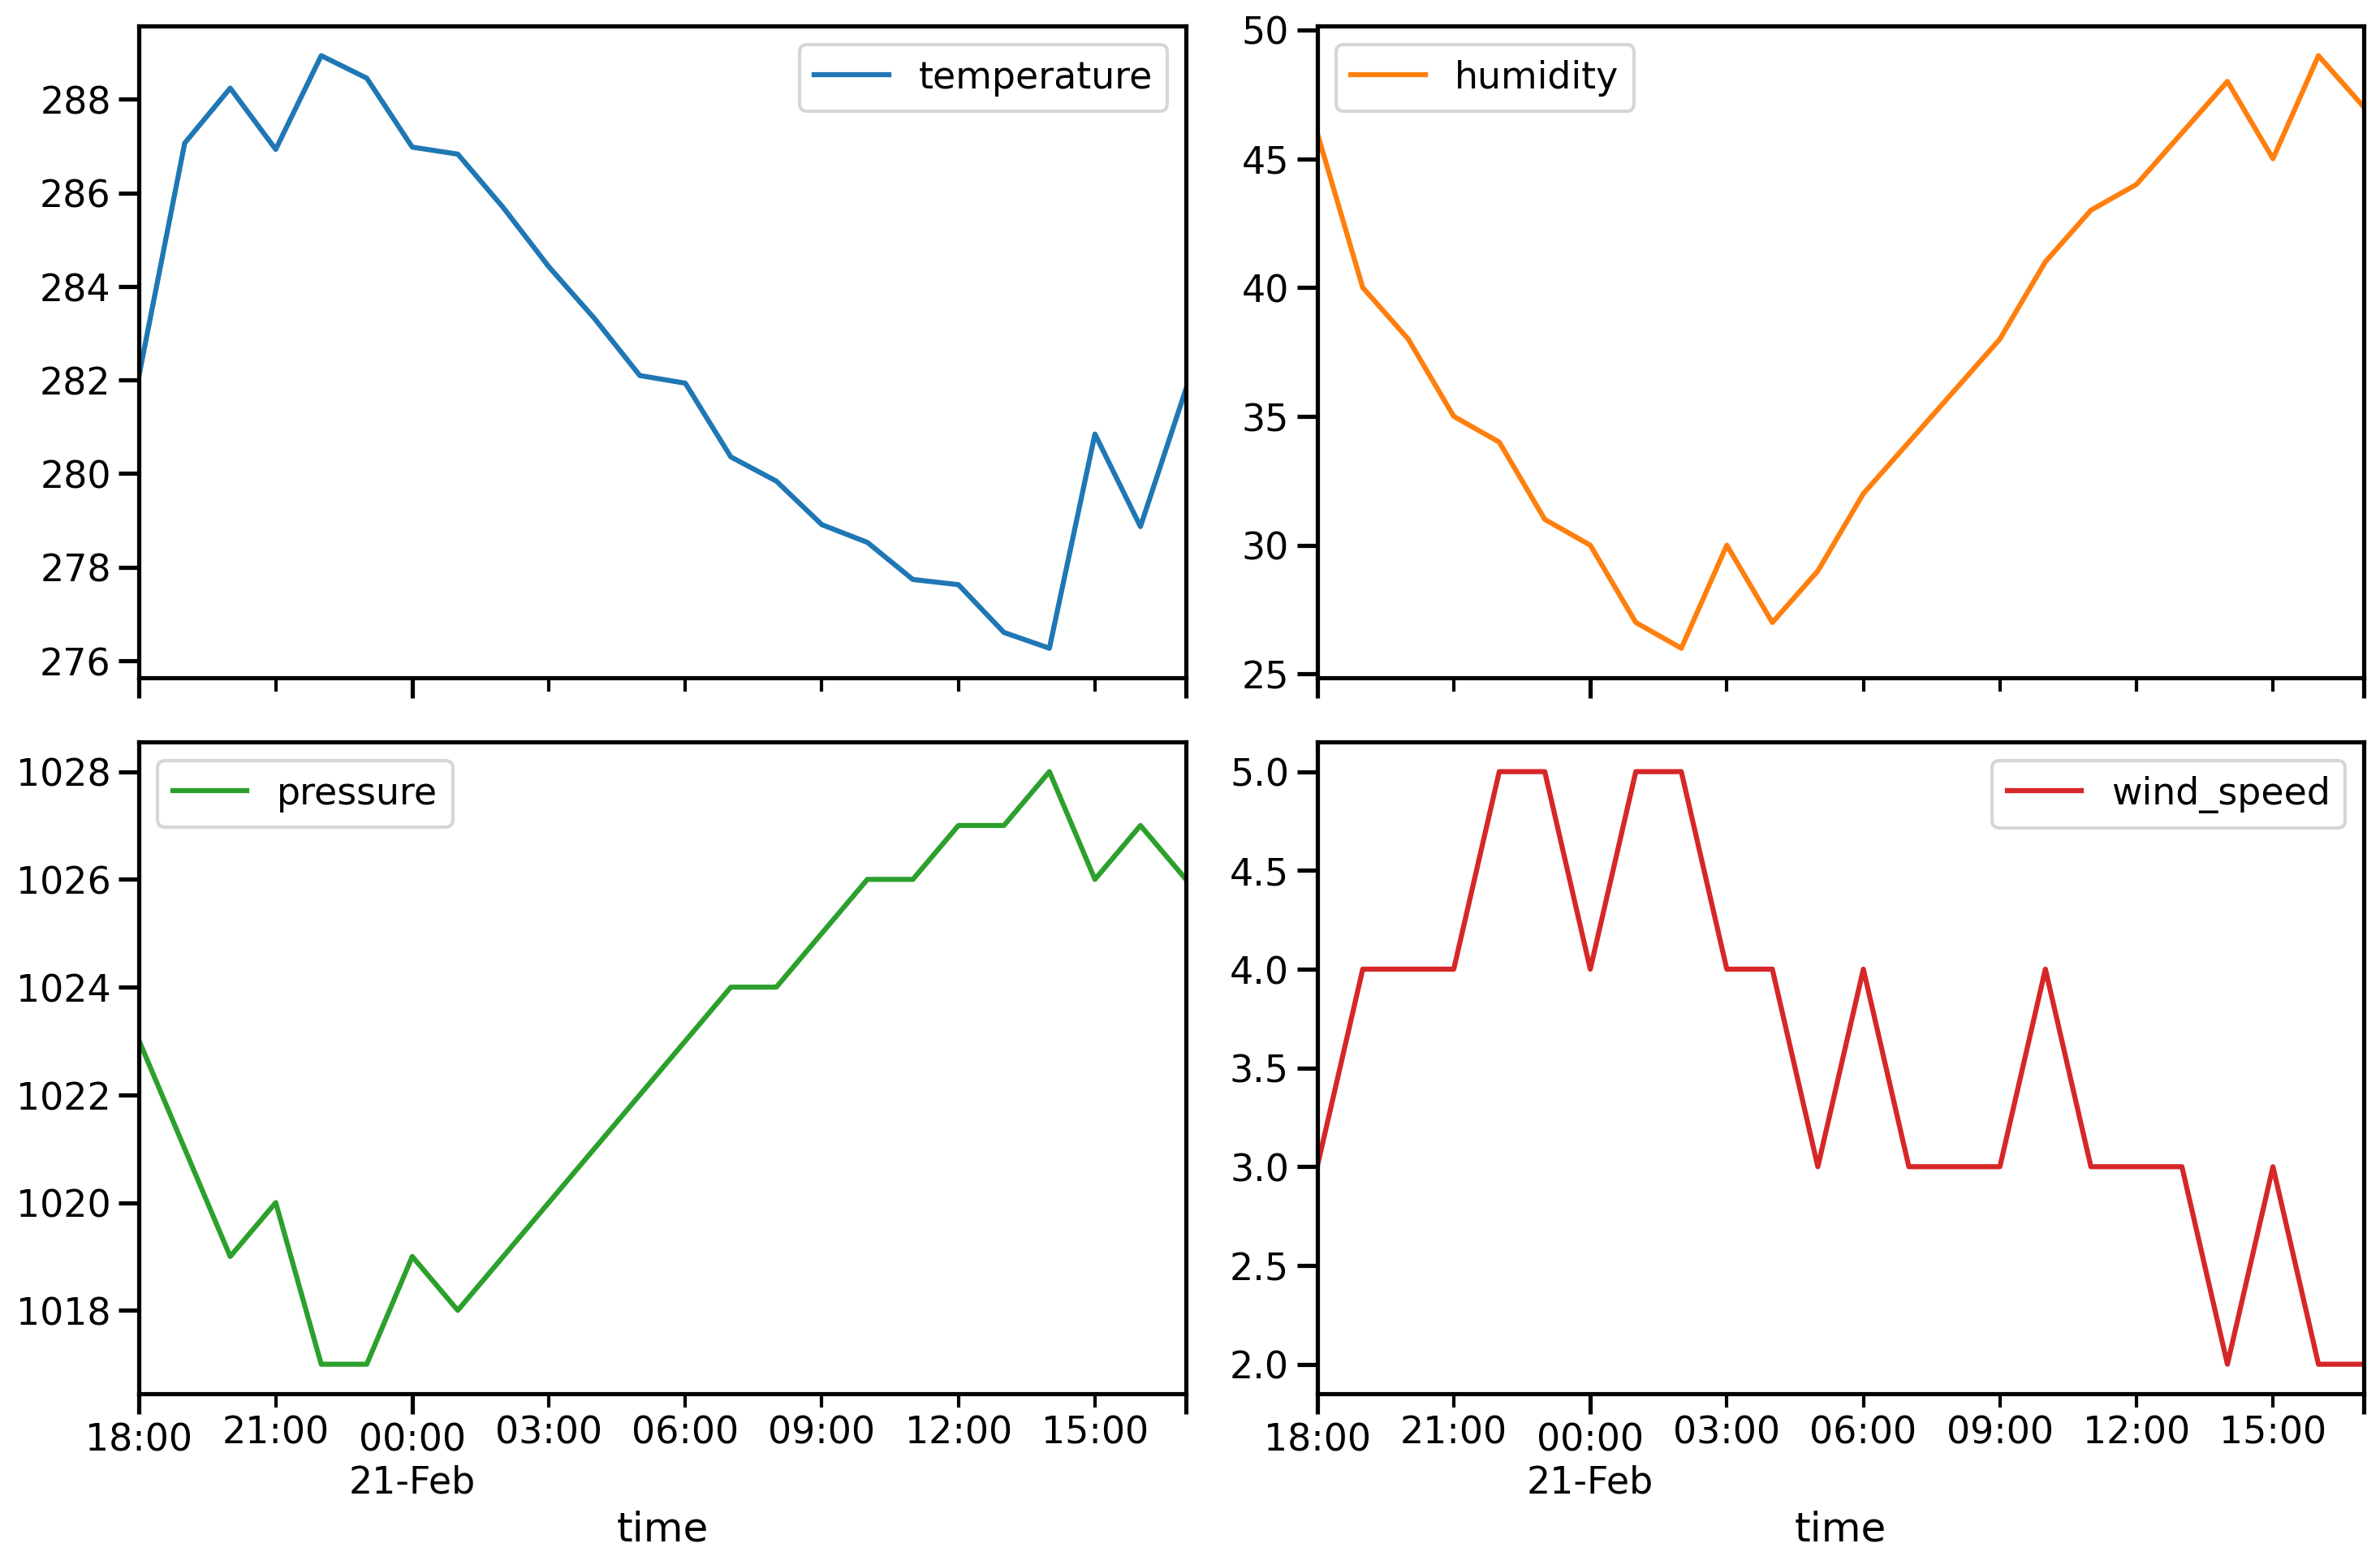

In [118]:
train_X.loc['Albuquerque/1112/1'].plot(subplots=True, layout=(2, 2), figsize=[15, 10])
plt.tight_layout()

In [119]:
train_y.loc['Albuquerque/1112/1'].head(24)

,temperature,humidity,pressure,wind_speed
time,,,,
2015-02-21 18:00:00,282.091500,44.0,1024.0,3.0
2015-02-21 19:00:00,285.914000,43.0,1023.0,3.0
2015-02-21 20:00:00,287.083000,40.0,1021.0,4.0
2015-02-21 21:00:00,286.046500,37.0,1022.0,5.0
2015-02-21 22:00:00,287.950667,34.0,1019.0,6.0
2015-02-21 23:00:00,287.649333,31.0,1019.0,6.0
2015-02-22 00:00:00,285.892000,30.0,1021.0,4.0
2015-02-22 01:00:00,286.076000,26.0,1020.0,5.0
2015-02-22 02:00:00,284.804000,25.0,1021.0,4.0


In [120]:
#adding city, date and time as features; converting city to number by one hot encoding

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()


train_X_added = train_X

def extract_city_and_encode(df):
    # Extract city name from the MultiIndex
    df['city'] = df.index.get_level_values(0).str.split('/').str[0]
    
    # Initialize LabelEncoder
    label_encoder = LabelEncoder()
    
    # Apply label encoding to the city column
    df['city'] = label_encoder.fit_transform(df['city'].astype(str))/1.0
    
    return df, label_encoder


train_X_added, label_encoder = extract_city_and_encode(train_X)
# Extracting city name from the first level of the MultiIndex
train_X_added['city'] = train_X.index.get_level_values(0).str.split('/').str[0]
train_X_added['city'] = label_encoder.fit_transform(train_X_added['city'].astype(str))
# Extracting date and time from the second level of the MultiIndex
# date is converted to month + date/31
# time is converted to hour + miniute/60
train_X_added['month'] = (pd.to_datetime(train_X.index.get_level_values(1)).strftime('%m').astype('int'))
train_X_added['time'] = (pd.to_datetime(train_X.index.get_level_values(1)).strftime('%H').astype('float64') + 
                        pd.to_datetime(train_X.index.get_level_values(1)).strftime('%M').astype('float64') / 60)

# Resetting the index since we have extracted the necessary information
train_X_added.reset_index(drop=True, inplace=True)

# Checking the new structure of the training and validation datasets
train_X_added.info()

# Displaying the first few rows of the modified datasets to verify additional features
train_X_added.head()

validate_X_added, label_encoder = extract_city_and_encode(validate_X)
# Extracting city name from the first level of the MultiIndex
validate_X_added['city'] = validate_X.index.get_level_values(0).str.split('/').str[0]
validate_X_added['city'] = label_encoder.fit_transform(validate_X_added['city'].astype(str))
# Extracting date and time from the second level of the MultiIndex
# date is converted to month + date/31
# time is converted to hour + miniute/60
validate_X_added['month'] = (pd.to_datetime(validate_X.index.get_level_values(1)).strftime('%m').astype('int'))
#                          pd.to_datetime(validate_X.index.get_level_values(1)).strftime('%d').astype('float32') / 31)
validate_X_added['time'] = (pd.to_datetime(validate_X.index.get_level_values(1)).strftime('%H').astype('float64') + 
                        pd.to_datetime(validate_X.index.get_level_values(1)).strftime('%M').astype('float64') / 60)

# Resetting the index since we have extracted the necessary information
validate_X_added.reset_index(drop=True, inplace=True)

# Checking the new structure of the validateing and validation datasets
validate_X_added.info()

# Displaying the first few rows of the modified datasets to verify additional features
validate_X_added.head()

test_X_added, label_encoder = extract_city_and_encode(test_X)
# Extracting city name from the first level of the MultiIndex
test_X_added['city'] = test_X.index.get_level_values(0).str.split('/').str[0]
test_X_added['city'] = label_encoder.fit_transform(test_X_added['city'].astype(str))
# Extracting date and time from the second level of the MultiIndex
# date is converted to month + date/31
# time is converted to hour + miniute/60
test_X_added['month'] = (pd.to_datetime(test_X.index.get_level_values(1)).strftime('%m').astype('int'))
#                          pd.to_datetime(test_X.index.get_level_values(1)).strftime('%d').astype('float32') / 31)
test_X_added['time'] = (pd.to_datetime(test_X.index.get_level_values(1)).strftime('%H').astype('float64') + 
                        pd.to_datetime(test_X.index.get_level_values(1)).strftime('%M').astype('float64') / 60)

# Resetting the index since we have extracted the necessary information
test_X_added.reset_index(drop=True, inplace=True)

# Checking the new structure of the testing and validation datasets
test_X_added.info()

# Displaying the first few rows of the modified datasets to verify additional features
test_X_added.head()

score_X_added, label_encoder = extract_city_and_encode(score_X)
# Extracting city name from the first level of the MultiIndex
score_X_added['city'] = score_X.index.get_level_values(0).str.split('/').str[0]
score_X_added['city'] = label_encoder.fit_transform(score_X_added['city'].astype(str))
# Extracting date and time from the second level of the MultiIndex
# date is converted to month + date/31
# time is converted to hour + miniute/60
score_X_added['month'] = (pd.to_datetime(score_X.index.get_level_values(1)).strftime('%m').astype('int'))
#                          pd.to_datetime(score_X.index.get_level_values(1)).strftime('%d').astype('float32') / 31)
score_X_added['time'] = (pd.to_datetime(score_X.index.get_level_values(1)).strftime('%H').astype('float64') + 
                        pd.to_datetime(score_X.index.get_level_values(1)).strftime('%M').astype('float64') / 60)

# Resetting the index since we have extracted the necessary information
score_X_added.reset_index(drop=True, inplace=True)

# Checking the new structure of the scoreing and validation datasets
score_X_added.info()

# Displaying the first few rows of the modified datasets to verify additional features
score_X_added.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826464 entries, 0 to 826463
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   temperature  826464 non-null  float64
 1   humidity     826464 non-null  float64
 2   pressure     826464 non-null  float64
 3   wind_speed   826464 non-null  float64
 4   city         826464 non-null  int64  
 5   month        826464 non-null  int64  
 6   time         826464 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 44.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54912 entries, 0 to 54911
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  54912 non-null  float64
 1   humidity     54912 non-null  float64
 2   pressure     54912 non-null  float64
 3   wind_speed   54912 non-null  float64
 4   city         54912 non-null  int64  
 5   month        54912 non-null  int64  
 6   tim

,temperature,humidity,pressure,wind_speed,city,month,time
0,292.03,49.0,1027.0,3.0,0,7,13.0
1,292.07,56.0,1027.0,3.0,0,7,14.0
2,295.62,49.0,1028.0,2.0,0,7,15.0
3,296.63,44.0,1028.0,3.0,0,7,16.0
4,299.15,36.0,1027.0,3.0,0,7,17.0


In [121]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_X)

scaled_X = {
    'train': scaler.transform(train_X_added),
    'validate': scaler.transform(validate_X_added),
    'test': scaler.transform(test_X_added),
    'score': scaler.transform(score_X_added),
}

In [122]:
# Keras RNN cells expect inputs with 3 dimensions:
# (batch_size, condition_window, features_length)
# Each RNN cell takes a vector of features_length
# at each time step of condition_window.
# Internal RNN cell state is reset between different batch samples.

# Let's review current shapes of the input, and the desired shapes.

def expected_X_shape(actual_X_shape):
    return (int(actual_X_shape[0]/condition_window), condition_window, features_length)

def expected_y_shape(actual_y_shape):
    return (int(actual_y_shape[0]/prediction_window), prediction_window)


pd.DataFrame({
    'actual shape': [
        train_X_added.shape, 
        train_y.shape,
    ],
    'expected shape': [
        expected_X_shape(train_X_added.shape), 
        expected_y_shape(train_y.shape), 
    ],
}, index=['train_X', 'train_y'])

,actual shape,expected shape
train_X,"(826464, 7)","(34436, 24, 7)"
train_y,"(826464, 4)","(34436, 24)"


In [123]:
# Exepected shape can be achieved with a simple reshape call.
# Note that these are not Pandas data frames any more,
# but Numpy n-dimensional arrays.
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html

def frame_to_ndarray(frame_X, frame_y):
    X_nd = frame_X.reshape(-1, condition_window, features_length).astype('float32')
    y_nd = frame_y['temperature'].values.reshape(-1, prediction_window).astype('float32')
    return X_nd, y_nd

def frame_to_ndarray_score(frame_X):
    X_nd = frame_X.reshape(-1, condition_window, features_length).astype('float32')
    return X_nd

train_X_nd, train_y_nd = frame_to_ndarray(scaled_X['train'], train_y)
validate_X_nd, validate_y_nd = frame_to_ndarray(scaled_X['validate'], validate_y)
test_X_nd, test_y_nd = frame_to_ndarray(scaled_X['test'], test_y)
score_X_nd = frame_to_ndarray_score(scaled_X['score'])
#score_X_nd = frame_to_ndarray(scaled_X['score'], score_y)

# Task: Transform other segments of the dataset (test, and score).
# Enter your code here.

In [124]:
# Let's confirm the expected shape.

pd.DataFrame({
    'actual shape': [
        train_X_nd.shape, 
        train_y_nd.shape,
        validate_X_nd.shape,
        validate_y_nd.shape,
        test_X_nd.shape,
        test_y_nd.shape,
        score_X_nd.shape,
    ],
    'expected shape': [
        expected_X_shape(train_X.shape), 
        expected_y_shape(train_y.shape), 
        expected_X_shape(validate_X.shape), 
        expected_y_shape(validate_y.shape), 
        expected_X_shape(test_X.shape), 
        expected_y_shape(test_y.shape),
        expected_X_shape(score_X.shape) 
   ]},
    index=['train_X', 'train_y', 'validate_X', 'validate_y', 'test_X', 'test_y', 'score_X']
)

,actual shape,expected shape
train_X,"(34436, 24, 7)","(34436, 24, 7)"
train_y,"(34436, 24)","(34436, 24)"
validate_X,"(2288, 24, 7)","(2288, 24, 7)"
validate_y,"(2288, 24)","(2288, 24)"
test_X,"(2177, 24, 7)","(2177, 24, 7)"
test_y,"(2177, 24)","(2177, 24)"
score_X,"(2399, 24, 7)","(2399, 24, 7)"


In [145]:
from keras.layers import GRU, Dense, BatchNormalization, Dropout, LSTM
from tensorflow.keras.layers import MultiHeadAttention, Attention
from keras.models import Sequential
from keras.initializers import GlorotUniform
from keras.regularizers import l1_l2

reg_factor = 0.035

# IMPORTANT: In order to pass the assignment, you need
# to improve the architecture and/or training procedure of this model.
# You CAN NOT submit the model as is. Please add plain English Python
# comments on how you modified the model and/or training procedure.

layers = [
        LSTM(
            input_shape=(condition_window, features_length),
            units=64,
            return_sequences=True,  # support another recurrent layer below
            activation='relu',  # Change the output activation to ReLU
            kernel_regularizer=l1_l2(l1=reg_factor, l2=reg_factor),
            recurrent_regularizer=l1_l2(l1=reg_factor, l2=reg_factor),
            recurrent_activation='hard_sigmoid',  # Change the gate activation to hard sigmoid
            kernel_initializer=GlorotUniform(seed=42),
            recurrent_initializer=GlorotUniform(seed=43),
            #use_cudnn=True,
        ),
        Dropout(0.2),
        BatchNormalization(),
        
        LSTM(
            units=64,
            return_sequences=True,  # support another recurrent layer below
            kernel_regularizer=l1_l2(l1=reg_factor, l2=reg_factor),
            recurrent_regularizer=l1_l2(l1=reg_factor, l2=reg_factor),
            activation='relu',  # Change the output activation to ReLU
            recurrent_activation='hard_sigmoid',  # Change the gate activation to hard sigmoid
            kernel_initializer=GlorotUniform(seed=42),
            recurrent_initializer=GlorotUniform(seed=43),
            #use_cudnn=True,
        ),
        Dropout(0.2),
        BatchNormalization(),

        LSTM(
            units=64,
            return_sequences=False,  
            kernel_regularizer=l1_l2(l1=reg_factor, l2=reg_factor),
            recurrent_regularizer=l1_l2(l1=reg_factor, l2=reg_factor),
            activation='relu',  # Change the output activation to ReLU
            recurrent_activation='hard_sigmoid',  # Change the gate activation to hard sigmoid
            kernel_initializer=GlorotUniform(seed=42),
            recurrent_initializer=GlorotUniform(seed=43),
            #use_cudnn=True,
        ),
        
        Dropout(0.2),
        BatchNormalization(),
        Dense(
            units=prediction_window,
            kernel_initializer=GlorotUniform(seed=48),
            activation='linear'
        )
]

model = Sequential(layers)

In [146]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 24, 64)         │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 24, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 24, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 24, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,808 (339.09 KB)

 Trainable params: 86,424 (337.59 KB)

 Non-trainable params: 384 (1.50 KB)

In [148]:
#!pip install mlflow

import mlflow
import mlflow.keras
mlflow.set_experiment("weather_04_LSTM_month_reg0.035")


<Experiment: artifact_location='file:///app/mlflow/153407123304214709', creation_time=1729568119534, experiment_id='153407123304214709', last_update_time=1729568119534, lifecycle_stage='active', name='weather_04_LSTM_month_reg0.035', tags={}>

Epoch 1/30
539/539 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 19.9891 - mean_absolute_error: 3.2427 - mean_error: -0.0040 - r2_score: 0.8684 - val_loss: 26.0211 - val_mean_absolute_error: 3.8449 - val_mean_error: 1.6933 - val_r2_score: 0.1630 - learning_rate: 0.0010
Epoch 2/30
539/539 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 20.2670 - mean_absolute_error: 3.2563 - mean_error: 0.0747 - r2_score: 0.8662 - val_loss: 22.5602 - val_mean_absolute_error: 3.5051 - val_mean_error: 0.5435 - val_r2_score: 0.2734 - learning_rate: 0.0010
Epoch 3/30
539/539 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 20.1686 - mean_absolute_error: 3.2523 - mean_error: -0.1345 - r2_score: 0.8666 - val_loss: 25.1283 - val_mean_absolute_error: 3.7287 - val_mean_error: 0.3688 - val_r2_score: 0.2352 - learning_rate: 0.0010
Epoch 4/30
539/539 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 20.2785 - mean_absolute_error: 3.2603 - mean_error: -0.0648 - r2_score: 0.8654 - val_loss: 22.8040 - val_mean_absolute_error: 3.4898 - val_mean

2024/10/21 20:51:06 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/21 20:51:10 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpy5d1b76j/model, flavor: keras). Fall back to return ['keras==3.6.0']. Set logging level to DEBUG to see the full traceback. 
2024/10/21 20:51:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


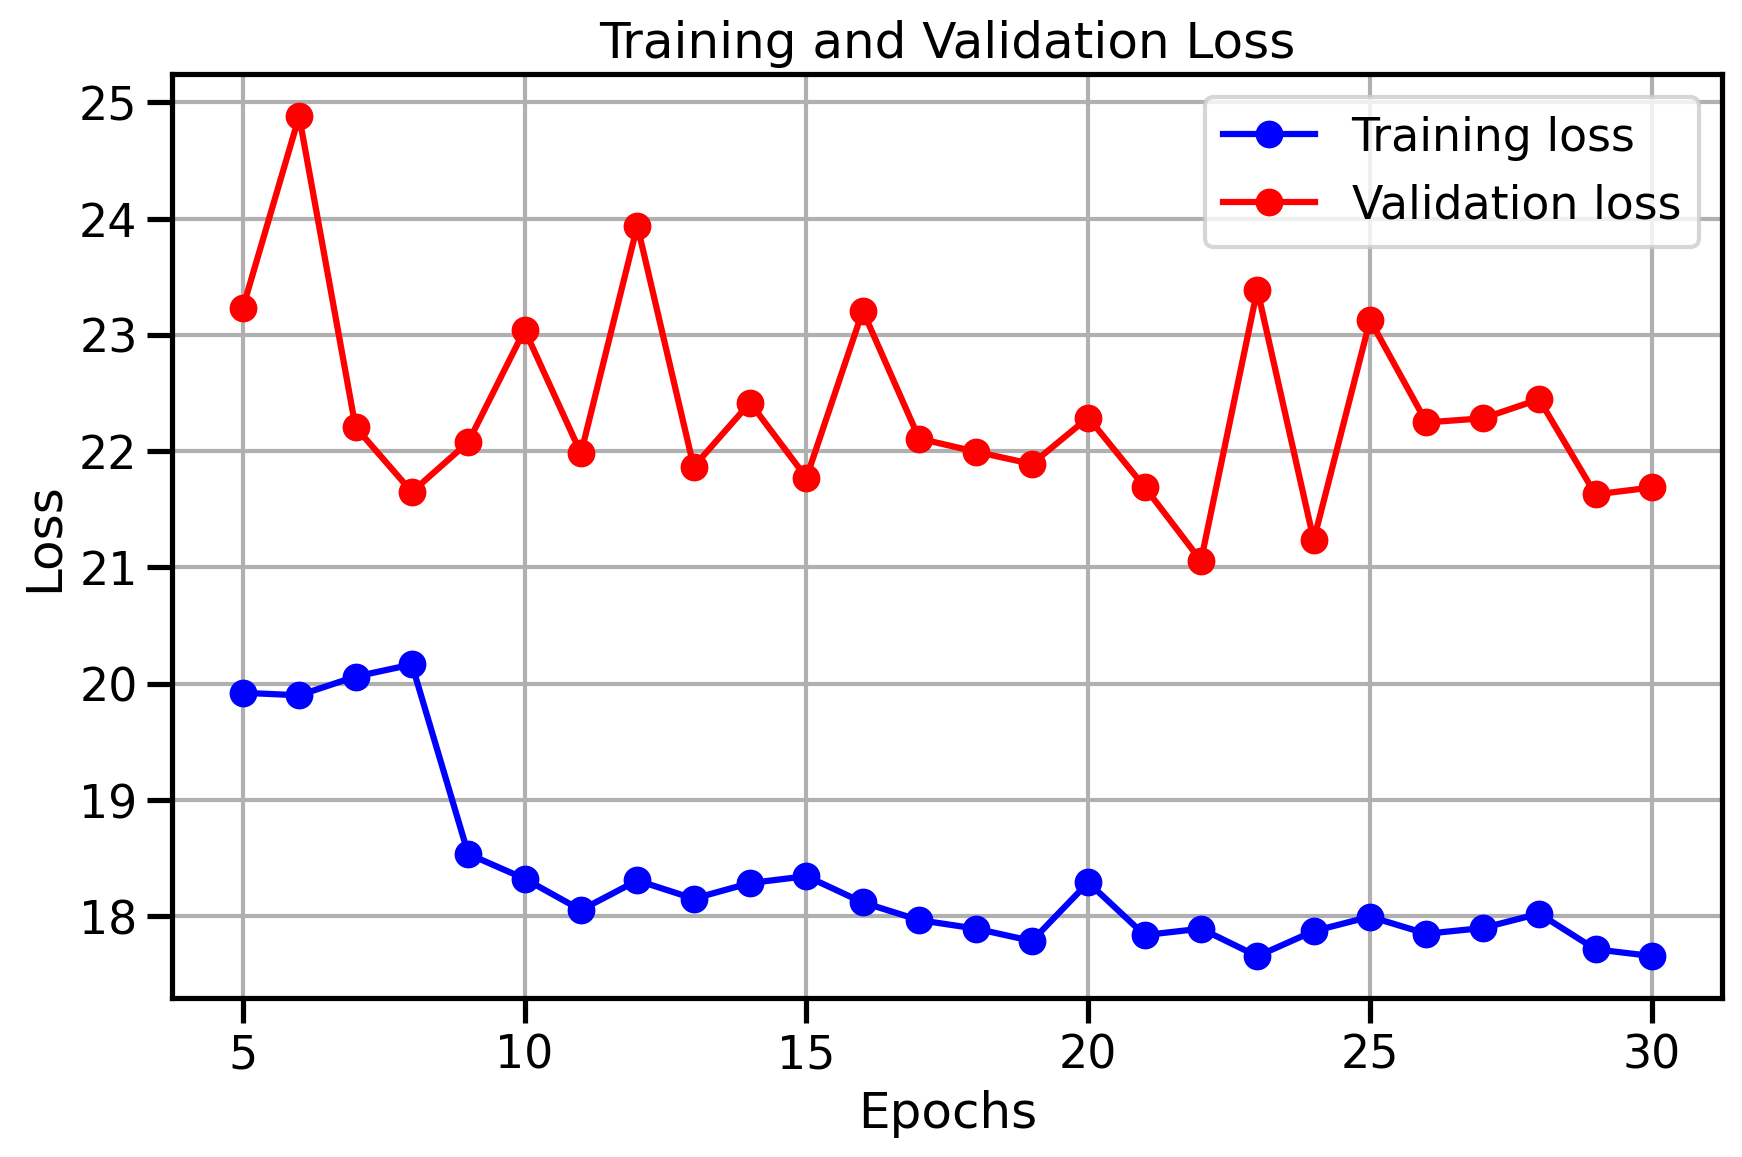

In [154]:
with mlflow.start_run():
    # Log parameters
    mlflow.log_param("reg_factor", reg_factor)
    mlflow.log_param("condition_window", condition_window)
    mlflow.log_param("features_length", features_length)
    mlflow.log_param("prediction_window", prediction_window)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=[
            'mean_absolute_error',
            mean_error,
            r2_score,
            ]
    )

    #

    from tensorflow.keras.callbacks import TerminateOnNaN, ReduceLROnPlateau, EarlyStopping

    # IMPORTANT: In order to pass the assignment, you need
    # to improve the architecture and/or training procedure of this model.
    # You CAN NOT submit the model as is. Please add plain English Python
    # comments on how you modified the model and/or training procedure.

    history = model.fit(
        train_X_nd,
        train_y_nd,
        validation_data=(validate_X_nd, validate_y_nd),
        epochs=30,
        batch_size=64,
        callbacks=[
            TerminateOnNaN(),
            ReduceLROnPlateau(
                monitor='loss',
                min_delta=0.1,
                patience=5,
                factor=0.1,
                cooldown=10,
                verbose=1
            ),
            EarlyStopping(
                monitor='loss',
                min_delta=0.1,
                patience=10
            )
        ]
    )

    # Log metrics
    mlflow.log_metric("train_loss", history.history['loss'][-1])
    mlflow.log_metric("val_loss", history.history['val_loss'][-1])

    # Log the model
    mlflow.keras.log_model(model, "model")

    # Log the loss plot
    plot_loss(history)
    #mlflow.log_artifact("loss_plot.png")


Epoch 1/50



KeyboardInterrupt



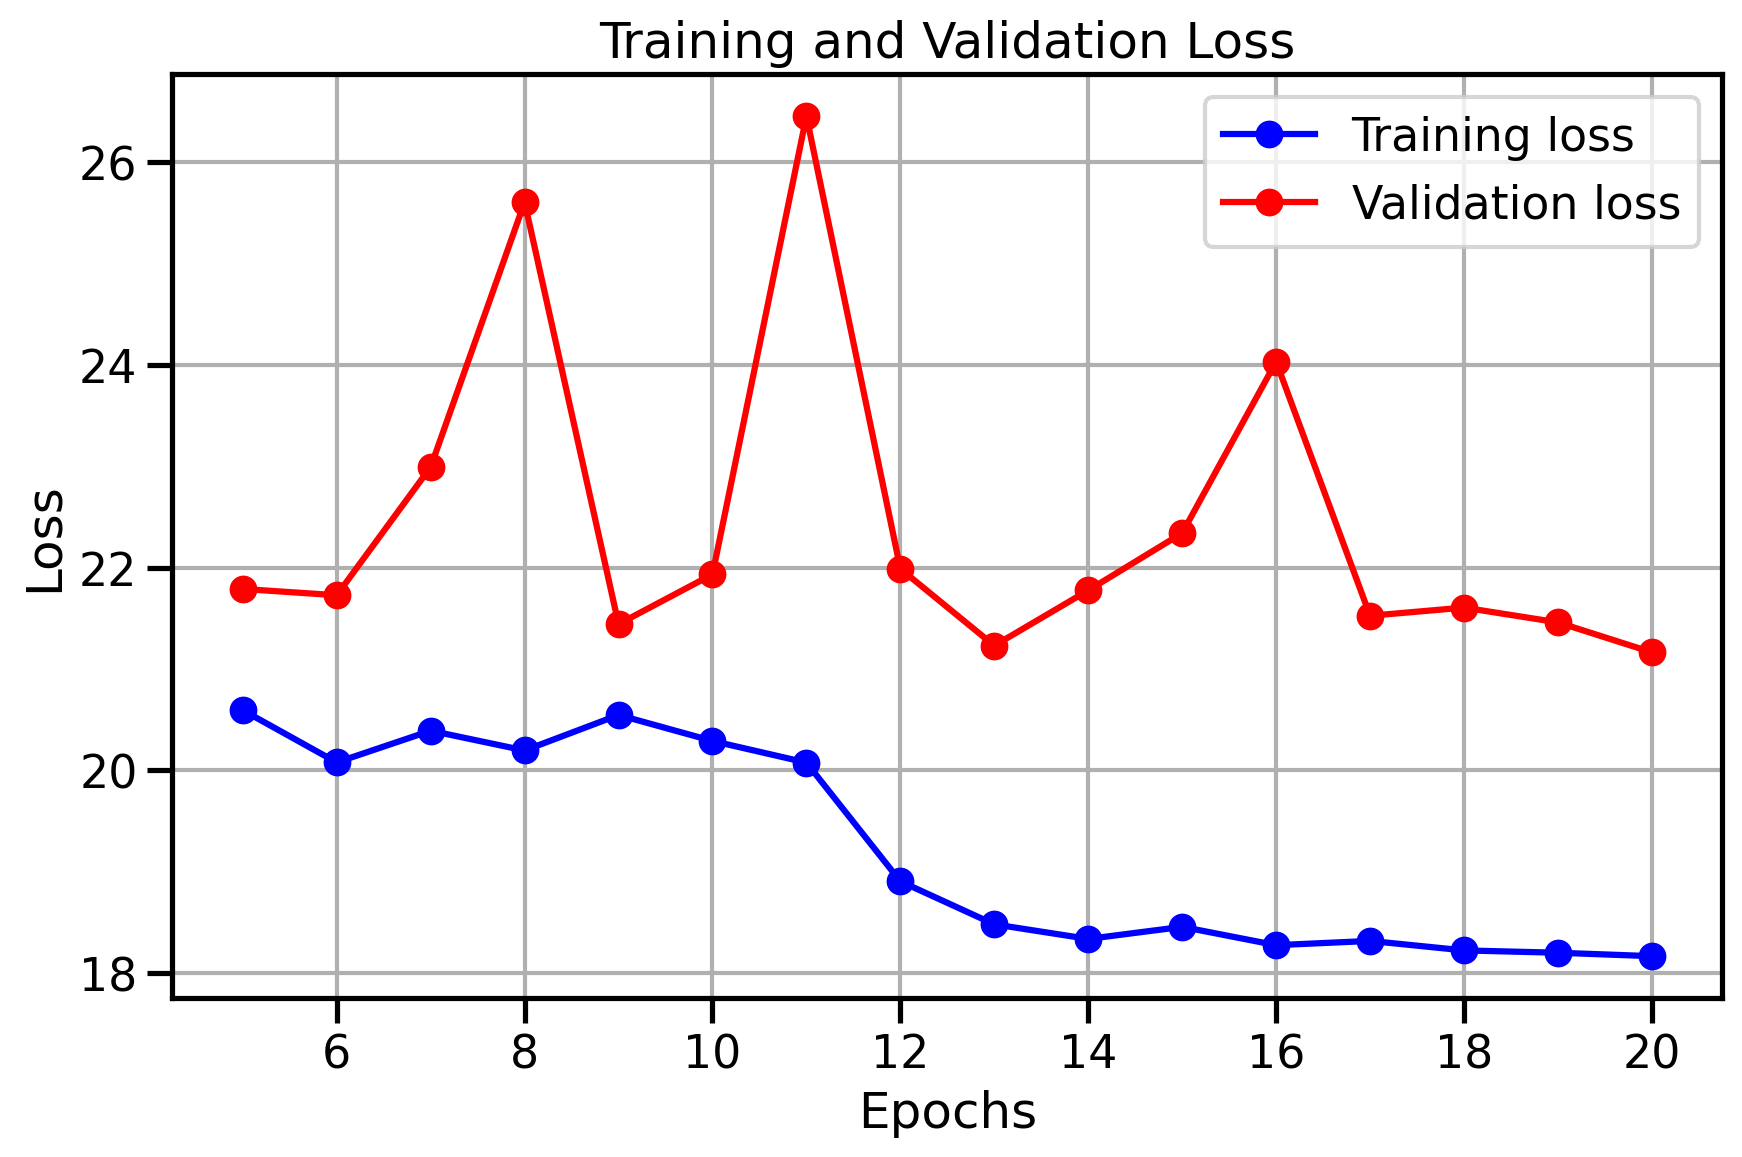

In [152]:
import matplotlib.pyplot as plt

def plot_loss(history):
    # Retrieve training and validation loss from history object
    n=4
    m=n+1
    train_loss = history.history['loss'][n:]
    val_loss = history.history['val_loss'][n:]
    epochs = range(m, len(train_loss) + m)

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_loss(history)

In [43]:
#training with 64k parameters, 128 batch size, reg=0.25
#history1_array=[]
history1_array.append(history)


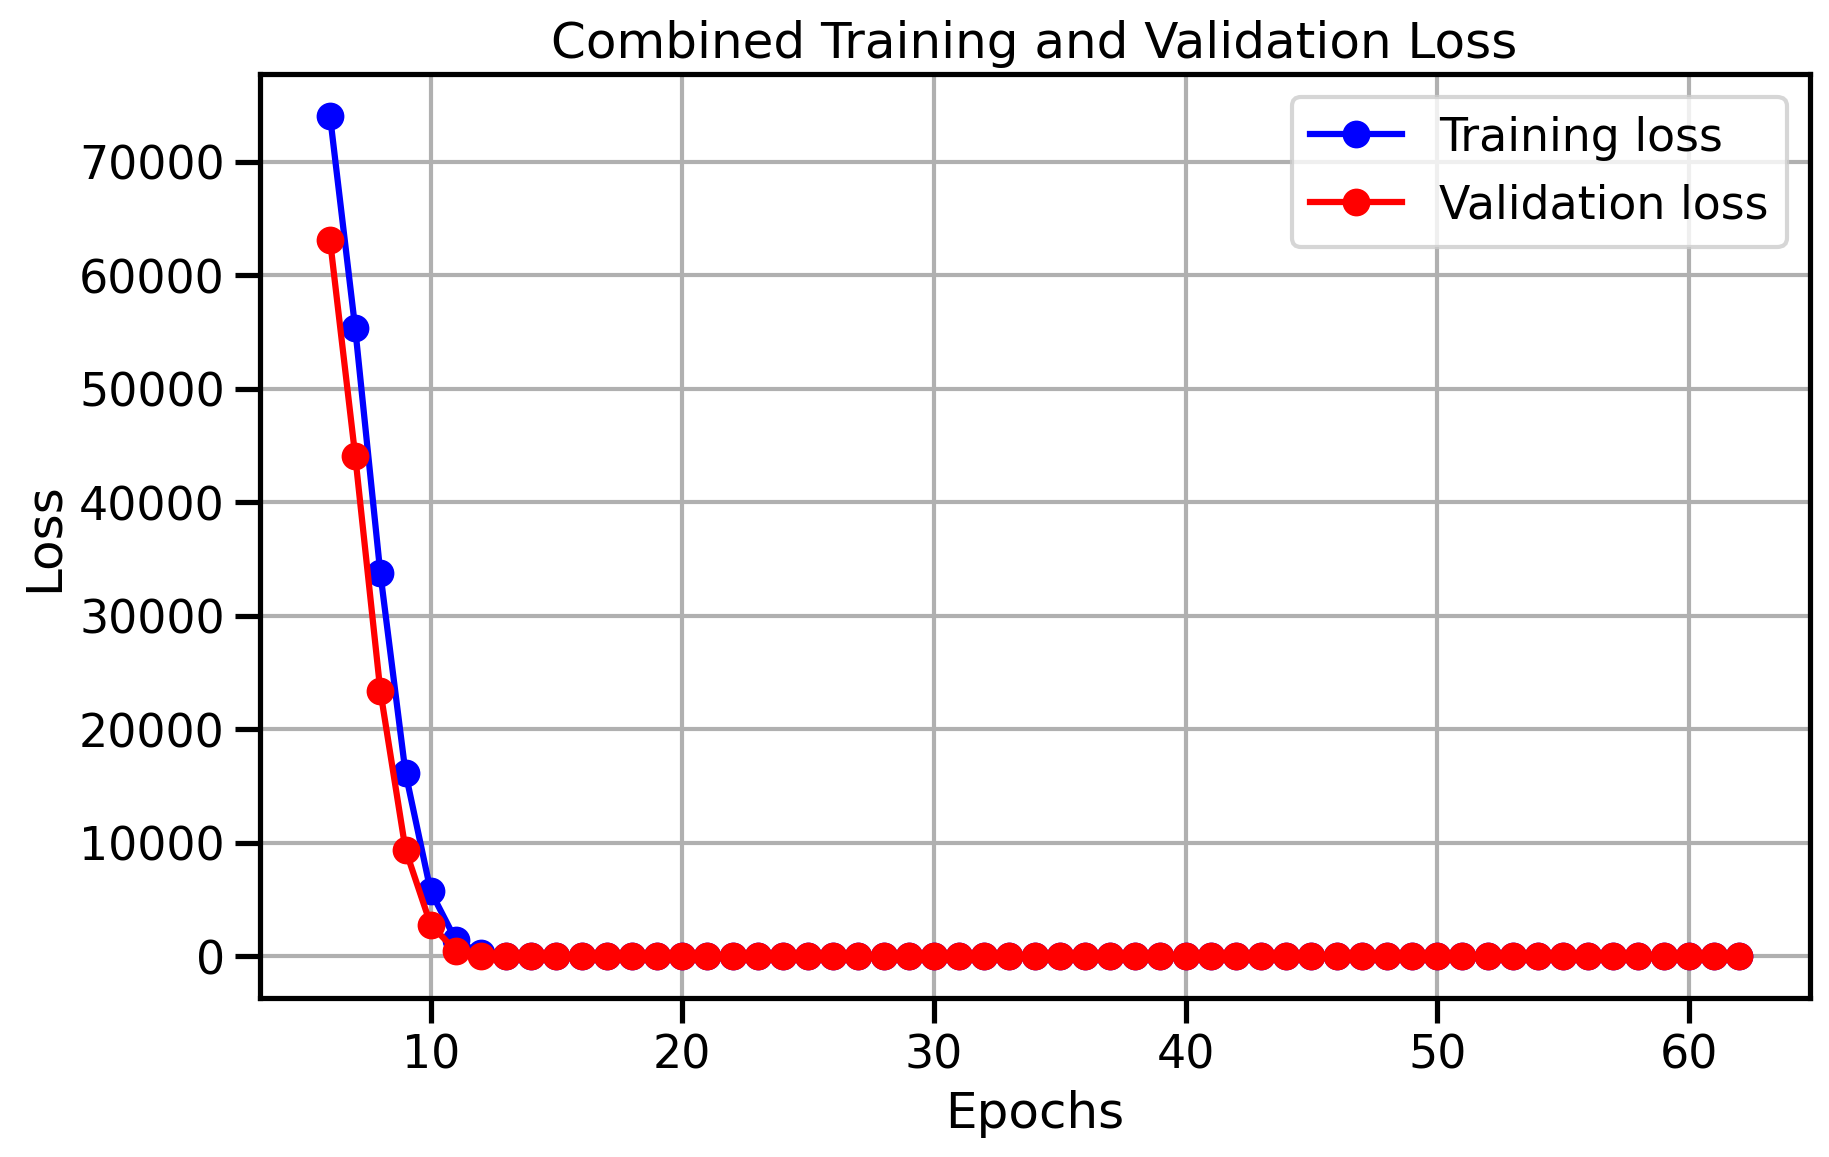

In [49]:
def combine_histories(history_list):
    combined_train_loss = []
    combined_val_loss = []
    combined_epochs = []
    epoch_offset = 6

    for history in history_list:
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        combined_train_loss.extend(train_loss)
        combined_val_loss.extend(val_loss)
        combined_epochs.extend(range(epoch_offset, epoch_offset + len(train_loss)))
        epoch_offset += len(train_loss)

    return combined_train_loss, combined_val_loss, combined_epochs
def plot_combined_loss(combined_train_loss, combined_val_loss, combined_epochs):
    plt.figure(figsize=(10, 6))
    plt.plot(combined_epochs, combined_train_loss, 'bo-', label='Training loss')
    plt.plot(combined_epochs, combined_val_loss, 'ro-', label='Validation loss')
    plt.title('Combined Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Combine the histories
combined_train_loss, combined_val_loss, combined_epochs = combine_histories(history1_array)

# Plot the combined loss
plot_combined_loss(combined_train_loss, combined_val_loss, combined_epochs)



In [155]:
# Note that Keras evaluates metrics in batches,
# which is okay for averaging-stable metrics like ME, MSE, and MAE,
# but R2 requires full dataset to evaluate precisely.

# This implies two things:
# 1) R2 as reported during training is not precise
# 2) when evaluating R2 after training, batch size must match dataset size

nd_array_by_segment = {
    'train': (train_X_nd, train_y_nd),
    'validate': (validate_X_nd, validate_y_nd),
    'test': (test_X_nd, test_y_nd)
}

metrics_by_segment = {
    segment: model.evaluate(
        X_nd, 
        y_nd, 
        verbose=0, 
        batch_size=2**13
    )
    for segment, (X_nd, y_nd) in nd_array_by_segment.items()
}

rnn_metrics = pd.concat([
    pd.DataFrame(
        data=[metrics], 
        columns=['MSE', 'MAE', 'ME', 'R2'], 
        index=[segment]
    )
    for segment, metrics in metrics_by_segment.items()
])

rnn_metrics = pd.DataFrame([rnn_metrics.unstack()], index=['rnn'])\
    .swaplevel(axis=1, i=0, j=1)\
    .reindex(nd_array_by_segment.keys(), axis=1, level=0)\
    .round(2)


rnn_metrics

train                   validate                     test              \
       MSE   MAE    ME    R2      MSE   MAE    ME    R2    MSE   MAE    ME   
rnn  11.98  2.46  0.25  0.91    21.69  3.48  0.37  0.77  14.14  2.76 -0.74   

           
       R2  
rnn  0.83

In [52]:
from utils import SegmentDataset, baseline_metrics

segment_names = ['train', 'validate']
panel_dataset = SegmentDataset.from_pq_workdir(prefix, segment_names, ['x', 'y'])
baseline_metrics = baseline_metrics(panel_dataset)

/home/sagemaker-user/collegium/m03_rnn/utils.py:263: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  return reg.stack("time")
/home/sagemaker-user/collegium/m03_rnn/utils.py:263: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  return reg.stack("time")


In [202]:
pd.concat([
    baseline_metrics,
    rnn_metrics
], axis=0).loc[:, [('train', 'MSE'), ('train', 'R2'), ('validate', 'MSE'), ('validate', 'R2')]].round(2)

train       validate      
              MSE    R2      MSE    R2
mean        26.77  0.80    37.23  0.58
constant    21.82  0.84    40.25  0.54
regression  30.53  0.78    29.94  0.66
rnn         21.45  0.85    26.09  0.72

TypeError: object of type 'numpy.float64' has no len()

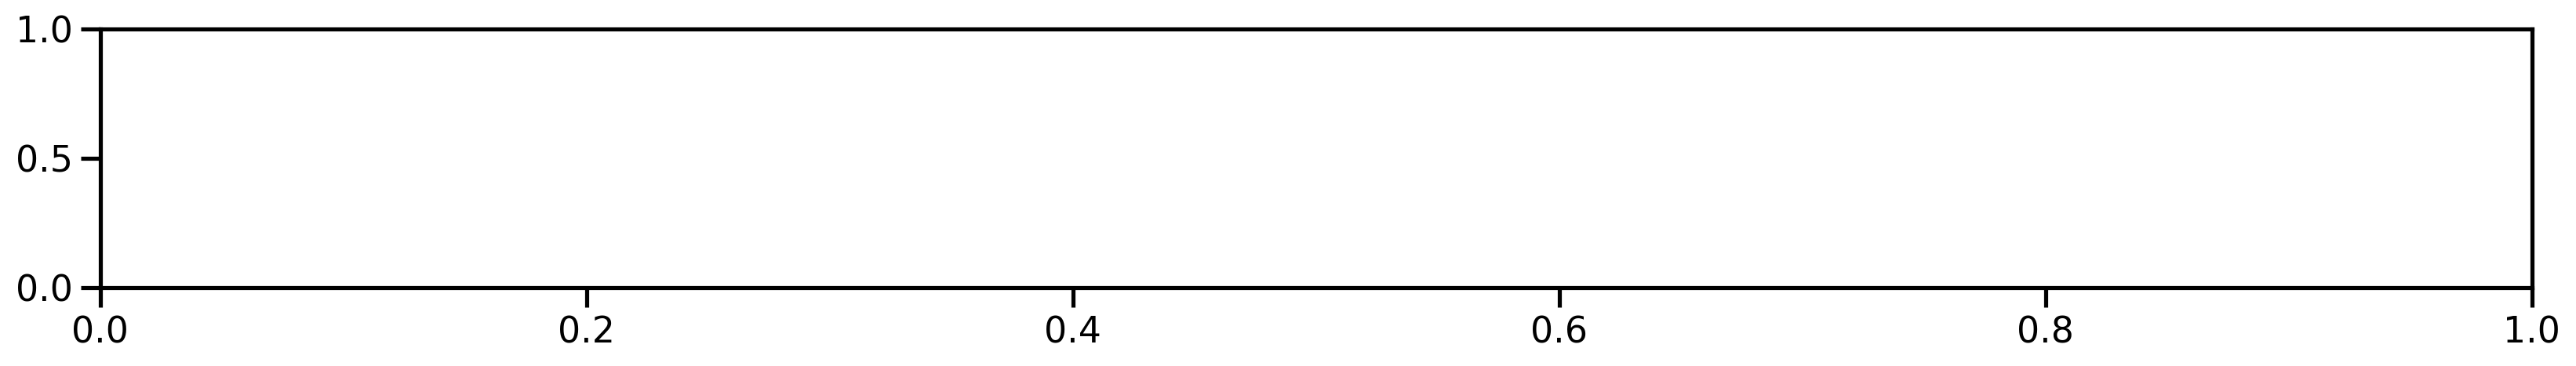

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_time_series_forecasts(past, future, forecast, samples=6):
    plt.figure(figsize=(20, 15))
    
    if isinstance(past, pd.DataFrame):
        num_samples = min(past.shape[0], samples)
        sample_indices = np.random.choice(past.index, num_samples, replace=False)
    else:
        num_samples = min(len(past), samples)
        sample_indices = np.random.choice(range(len(past)), num_samples, replace=False)
    
    for i, idx in enumerate(sample_indices):
        plt.subplot(num_samples, 1, i + 1)
        
        # Plot past data
        past_data = past.iloc[idx] if isinstance(past, pd.DataFrame) else past[idx]
        plt.plot(range(len(past_data)), past_data, label='Past', color='blue')
        
        # Plot forecast point
        forecast_point = forecast.iloc[idx] if isinstance(forecast, pd.Series) else forecast
        plt.scatter(len(past_data), forecast_point, color='red', label='Forecast', s=50)
        
        plt.legend()
        plt.title(f'Sample {idx}')
        plt.xlabel('Time Steps')
        plt.ylabel('Temperature')
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_time_series_forecasts(train_X_added['temperature'], train_y['temperature'], train_y_hat['temperature'], samples=6)

# Print data types and shapes for debugging
print("train_X_added['temperature']:")
print("Type:", type(train_X_added['temperature']))
print("Shape:", train_X_added['temperature'].shape)
print("\ntrain_y['temperature']:")
print("Type:", type(train_y['temperature']))
print("Shape:", train_y['temperature'].shape)
print("\ntrain_y_hat['temperature']:")
print("Type:", type(train_y_hat['temperature']))
print("Shape:", train_y_hat['temperature'].shape)


In [89]:
from utils import nd_target_like_panel#, plot_random_forecasts

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



# Assuming your data is structured correctly, you can call the function like this:
plot_time_series_forecasts(train_X_added['temperature'], train_y['temperature'], train_y_hat['temperature'], time_steps=24*7)  # Adjust time_steps as needed


print("Types of columns in train_X_added:")
print(train_X_added['temperature'].dtypes)

print("\nTypes of columns in train_y:")
print(train_y['temperature'].dtypes)

print("\nTypes of columns in train_y_hat:")
print(train_y_hat['temperature'].dtypes)


print(train_X_added['temperature'].index)
print(train_X_added['temperature'].index.values)
print(train_X_added['temperature'].index[0])  # First index value
print(train_X_added['temperature'].index[-1])  # Last index value

#plot_random_forecasts(
#    train_X_added['temperature'],
#    train_y['temperature'],
#    train_y_hat.rename(columns={'temperature': 'forecast'})
#)




TypeError: plot_time_series_forecasts() got an unexpected keyword argument 'time_steps'

In [90]:
# Predict using the model
predictions = model.predict(score_X_nd)

# Reshape the predictions to flatten them from (2399, 24) to (57576, 1)
flattened_predictions = predictions.reshape(-1, 1)

# Create the DataFrame with the flattened predictions
score_y_hat = pd.DataFrame(flattened_predictions, columns=['temperature'])

# Verify the shape
print(score_y_hat.shape)  # Should output (57576, 1)
score_y_hat.columns, score_y_hat.shape

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
(57576, 1)


(Index(['temperature'], dtype='object'), (57576, 1))

In [91]:
# Once you are satisfied with your model,
# your need to submit 4 files:
# 1. this notebook and/or any other Python scripts
# 2. Model definition in JSON format
# 3. Model parameters in H5 format
# 4. temperature forecast for the Score segment

import os
model_dir = 'weathernet_model'
os.makedirs(model_dir, exist_ok=True)

# Save model definition:
import json
with open(f'{model_dir}/keras_model.json', 'w') as f:
    model_json = json.dumps(json.loads(model.to_json()), indent=True)
    f.write(model_json)

# Save the learned parameters.
model.save_weights(f"{model_dir}/keras_parameters.weights.h5")

# Finally, let's save the forecast.
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')